In [83]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [84]:
# gridsearch on normal replay buffer
# switch prob A and B back
# Add replay buffer size as experiment axis
# Find Q* and compare with Q values from network

In [85]:
import os, sys

# Add to path the parent directory of this notebook dir

root_dir = os.path.dirname(
        os.path.dirname(os.path.realpath(".")))

sys.path.append(root_dir)

import yaml
import pandas as pd
import torch
import logging


import numpy as np
from rl_envs_forge.envs.grid_world.grid_world import GridWorld
from common.src.simple_dqn_agent import AgentDQN


from common.src.visualize import draw_simple_gridworld

from common.src.utils import create_random_policy, extract_V_from_Q_for_stochastic_policy, extract_V_from_Q, derive_policy_from_q_table
from common.src.policy_iteration import random_policy_evaluation_q_stochastic, policy_evaluation_v
from common.src.value_iteration import value_iteration_v, value_iteration_q
import common.src.yaml_utils

from common.src.distribution_src import ( 
                                         make_gridworld_env,
                                         GridWorldStandardizeWrapper, 
                                         random_select_starting_pos,
                                        randomize_walls_positions, 
                                        generate_train_test_split_with_valid_path,
                                        run_distribution_correction_experiment,
                                        compute_validation_bellmans_error,
                                        setup_dqn_agent,
                                        run_dqn_distribution_correction_experiment
                                        )

from common.src.experiment_utils import (
    setup_logger
)

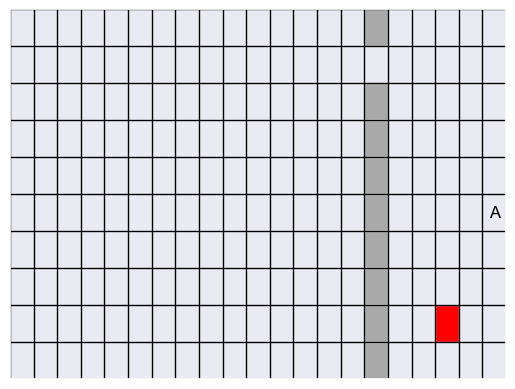

In [86]:
terminal_states = {(8, 18): 1}
start_state = (6, 1)
rows = 10
cols = 21
seed = 2
episode_limit = None
# episode_limit = 400

# random_walls = randomize_walls_positions(rows, cols, start_state, terminal_states, 0.2, seed=seed)
random_walls = {(0, 15),
 (2, 15),
 (3, 15),
 (4, 15),
 (5, 15),
 (6, 15),
 (7, 15),
 (8, 15),
 (9, 15)}
# random_walls = set()

# print(random_walls)
env = make_gridworld_env(
    rows,
    cols,
    start_state=start_state,
    p_success=1,
    terminal_states=terminal_states,
    seed=seed,
    walls=random_walls,
    episode_length_limit=episode_limit,
    standardize_wrapper=False,
    randomize_starting_position=True,
    random_stating_positions_parameters={"prob": 0.1,
                                         "space_A": ((0, 0), (9, 14)),
                                         "space_B": ((0, 16), (5, 20))},
)
env.render()

Optimal Policy: {(6, 18): <Action.DOWN: 2>, (4, 0): <Action.UP: 0>, (7, 17): <Action.RIGHT: 1>, (4, 9): <Action.UP: 0>, (5, 1): <Action.UP: 0>, (8, 0): <Action.UP: 0>, (3, 13): <Action.UP: 0>, (5, 10): <Action.UP: 0>, (8, 9): <Action.UP: 0>, (9, 8): <Action.UP: 0>, (0, 5): <Action.RIGHT: 1>, (2, 2): <Action.UP: 0>, (5, 19): <Action.DOWN: 2>, (8, 18): <Action.UP: 0>, (9, 17): <Action.UP: 0>, (0, 14): <Action.DOWN: 2>, (2, 11): <Action.UP: 0>, (6, 2): <Action.UP: 0>, (7, 1): <Action.UP: 0>, (1, 15): <Action.RIGHT: 1>, (6, 11): <Action.UP: 0>, (7, 10): <Action.UP: 0>, (6, 20): <Action.DOWN: 2>, (4, 2): <Action.UP: 0>, (7, 19): <Action.DOWN: 2>, (3, 6): <Action.UP: 0>, (5, 3): <Action.UP: 0>, (8, 2): <Action.UP: 0>, (9, 1): <Action.UP: 0>, (5, 12): <Action.UP: 0>, (8, 11): <Action.UP: 0>, (9, 10): <Action.UP: 0>, (0, 7): <Action.RIGHT: 1>, (2, 4): <Action.UP: 0>, (9, 19): <Action.UP: 0>, (0, 16): <Action.RIGHT: 1>, (1, 8): <Action.RIGHT: 1>, (6, 4): <Action.UP: 0>, (7, 3): <Action.UP: 0>, 

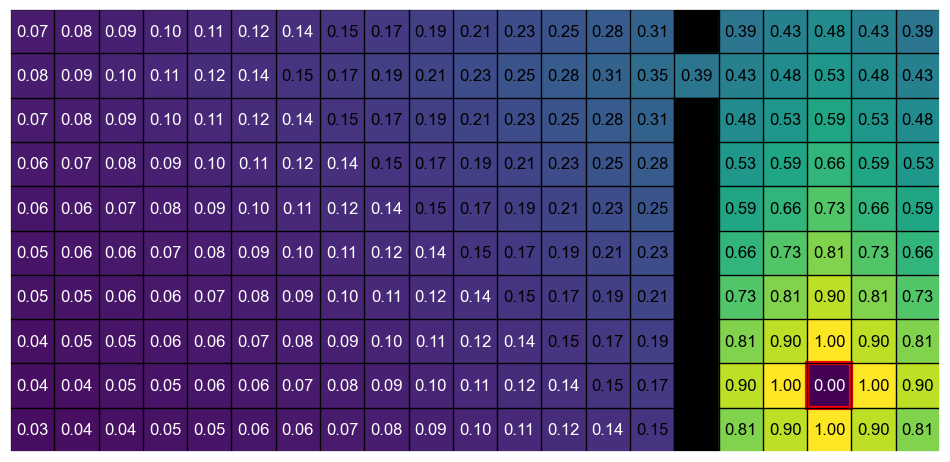

In [87]:

# Build the MDP representation
t_r_dict = env.mdp

# Parameters for policy iteration
gamma = 0.9
theta = 1e-6

# Assuming 't_r_dict' is your transition-reward dictionary from the GridWorld environment
states = list(set([s for s, _ in t_r_dict.keys()]))
actions = list(set([a for _, a in t_r_dict.keys()]))

optimal_policy, optimal_value_function = value_iteration_q(t_r_dict, states, actions)

print("Optimal Policy:", optimal_policy)
print("Value Function:", optimal_value_function)

# From Q extract V
states = list(set([s for s, _ in t_r_dict.keys()]))
V = {state: 0 for state in states}
optimal_V = policy_evaluation_v(states, optimal_policy, V, t_r_dict, gamma, theta)
print("Optimal Value Function:", optimal_V)

# Grid shape and walls for visualization
grid_shape = (env.rows, env.cols)
walls = env.walls  # Assuming walls are defined as a set of tuples (row, col)

# Draw the GridWorld with the optimal policy and value function
draw_simple_gridworld(
    grid_shape,
    walls,
    optimal_V,
    env.terminal_states,
    policy=None,
    enable_heatmap=True,
    figsize=(12, 7),
)

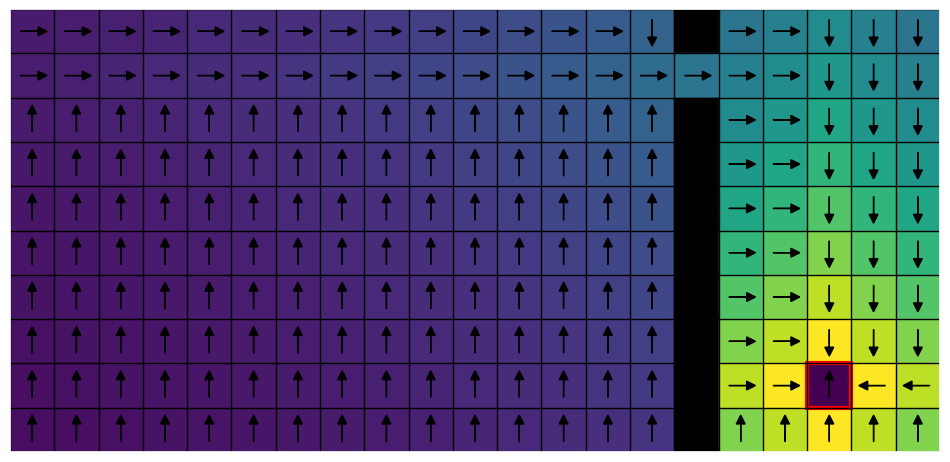

In [88]:
draw_simple_gridworld(
    grid_shape,
    walls,
    optimal_V,
    env.terminal_states,
    policy=optimal_policy,
    enable_heatmap=True,
    figsize=(12, 7),
)

In [89]:
optimal_value_function

{(6, 18): {<Action.UP: 0>: 0.7290000000000001,
  <Action.RIGHT: 1>: 0.7290000000000001,
  <Action.DOWN: 2>: 0.9,
  <Action.LEFT: 3>: 0.7290000000000001},
 (4, 0): {<Action.UP: 0>: 0.05814973700304011,
  <Action.RIGHT: 1>: 0.05814973700304011,
  <Action.DOWN: 2>: 0.04710128697246249,
  <Action.LEFT: 3>: 0.0523347633027361},
 (7, 17): {<Action.UP: 0>: 0.7290000000000001,
  <Action.RIGHT: 1>: 0.9,
  <Action.DOWN: 2>: 0.9,
  <Action.LEFT: 3>: 0.7290000000000001},
 (4, 9): {<Action.UP: 0>: 0.1500946352969992,
  <Action.RIGHT: 1>: 0.1500946352969992,
  <Action.DOWN: 2>: 0.12157665459056936,
  <Action.LEFT: 3>: 0.12157665459056936},
 (5, 1): {<Action.UP: 0>: 0.05814973700304011,
  <Action.RIGHT: 1>: 0.05814973700304011,
  <Action.DOWN: 2>: 0.04710128697246249,
  <Action.LEFT: 3>: 0.04710128697246249},
 (8, 0): {<Action.UP: 0>: 0.03815204244769462,
  <Action.RIGHT: 1>: 0.03815204244769462,
  <Action.DOWN: 2>: 0.030903154382632643,
  <Action.LEFT: 3>: 0.03433683820292516},
 (3, 13): {<Action.UP

### Now get the Q maps for the models in our experiments:

In [90]:
def find_matching_paths(root_dir):
    """
    Finds all matching paths under the given root directory using os.scandir.

    Parameters:
    - root_dir: The root directory to start searching from.

    Returns:
    - A list of matching paths.
    """
    matching_paths = []

    def recursive_scan(dir_path):
        with os.scandir(dir_path) as entries:
            for entry in entries:
                if entry.is_dir():
                    if len(os.path.relpath(entry.path, root_dir).split(os.sep)) == 2:
                        matching_paths.append(entry.path)
                    recursive_scan(entry.path)

    recursive_scan(root_dir)
    return matching_paths

def read_yaml_files(paths):
    """
    Reads the post_config.yaml file from each directory in the given list of paths.

    Parameters:
    - paths: List of directories to search for post_config.yaml.

    Returns:
    - A dictionary where keys are the directory paths and values are the contents of post_config.yaml.
    """
    config_data = {}

    for path in paths:
        yaml_file = os.path.join(path, "post_cfg.yaml")
        if os.path.exists(yaml_file):
            with open(yaml_file, "r") as file:
                config_data[path] = yaml.safe_load(file)
        else:
            print(f"post_config.yaml not found in {path}")

    return config_data


def flatten_stats(stats_dict):
    """
    Flattens the nested episode frames statistics in the given dictionary.

    Parameters:
    - stats_dict: The dictionary containing the statistics.

    Returns:
    - A flattened dictionary containing the episode frames statistics.
    """
    flattened = {}
    for key, value in stats_dict["episode_frames"].items():
        flattened[f"episode_frames_{key}"] = value
    return flattened

def read_yaml_files(paths):
    """
    Reads the post_config.yaml file from each directory in the given list of paths.

    Parameters:
    - paths: List of directories to search for post_config.yaml.

    Returns:
    - A dictionary where keys are the directory paths and values are the contents of post_config.yaml.
    """
    config_data = {}

    for path in paths:
        yaml_file = os.path.join(path, "post_cfg.yaml")
        if os.path.exists(yaml_file):
            with open(yaml_file, "r") as file:
                config_data[path] = yaml.safe_load(file)
        else:
            print(f"post_config.yaml not found in {path}")

    return config_data


def flatten_stats(stats_dict):
    """
    Flattens the nested episode frames statistics in the given dictionary.

    Parameters:
    - stats_dict: The dictionary containing the statistics.

    Returns:
    - A flattened dictionary containing the episode frames statistics.
    """
    flattened = {}
    for key, value in stats_dict["episode_frames"].items():
        flattened[f"episode_frames_{key}"] = value
    return flattened

# Example usage
root_dir = (
    r"D:\Work\repos\phd-research\experiments\dqn\results\2024Jul05-115126_configs"
)
matching_paths = find_matching_paths(root_dir)
config_data = read_yaml_files(matching_paths)

In [91]:
def filter_keys_by_lr_eps_size(d, target_lr, target_eps, hidden_size):
    filtered_keys = {k: v for k, v in d.items() if f"optim.args_.lr_{target_lr}" in k 
                     and f"optim.args_.eps_{target_eps}" in k
                     and f"agent_params.args_.hidden_size_{hidden_size}" in k}
    return filtered_keys

filtered_configs_dict = filter_keys_by_lr_eps_size(config_data, "0.001", "1e-06", 16)
len(filtered_configs_dict.keys()) 


20

In [92]:
cnt = 0
for key in filtered_configs_dict:
    config = filtered_configs_dict[key]
    cnt += 1
    
    if cnt == 6:
        break

In [93]:

logger = logging.getLogger(__name__)


agent = setup_dqn_agent(
        config=config,
        logger=logger,
        resume_training_path=key,
    )

states = list(set([s for s, _ in agent.train_env.mdp.keys()]))
actions = list(set([a for _, a in agent.train_env.mdp.keys()]))
q_table_model = agent.compute_q_table(states, actions, agent.train_env.standardize_state)
q_table_model

{(6, 18): {<Action.UP: 0>: 0.6954919,
  <Action.RIGHT: 1>: 0.71179575,
  <Action.DOWN: 2>: 0.8563813,
  <Action.LEFT: 3>: 0.71734357},
 (4, 0): {<Action.UP: 0>: 0.056153715,
  <Action.RIGHT: 1>: 0.07112385,
  <Action.DOWN: 2>: 0.066631466,
  <Action.LEFT: 3>: 0.051628806},
 (7, 17): {<Action.UP: 0>: 0.732214,
  <Action.RIGHT: 1>: 0.855521,
  <Action.DOWN: 2>: 0.8864776,
  <Action.LEFT: 3>: 0.74634075},
 (4, 9): {<Action.UP: 0>: 0.1264618,
  <Action.RIGHT: 1>: 0.12277003,
  <Action.DOWN: 2>: 0.10079084,
  <Action.LEFT: 3>: 0.098546885},
 (5, 1): {<Action.UP: 0>: 0.07337403,
  <Action.RIGHT: 1>: 0.065975666,
  <Action.DOWN: 2>: 0.058644876,
  <Action.LEFT: 3>: 0.056809522},
 (8, 0): {<Action.UP: 0>: 0.053900197,
  <Action.RIGHT: 1>: 0.04921988,
  <Action.DOWN: 2>: 0.049875803,
  <Action.LEFT: 3>: 0.04344719},
 (3, 13): {<Action.UP: 0>: 0.19852012,
  <Action.RIGHT: 1>: 0.19714937,
  <Action.DOWN: 2>: 0.15880093,
  <Action.LEFT: 3>: 0.15720502},
 (5, 10): {<Action.UP: 0>: 0.12482643,
  <Ac

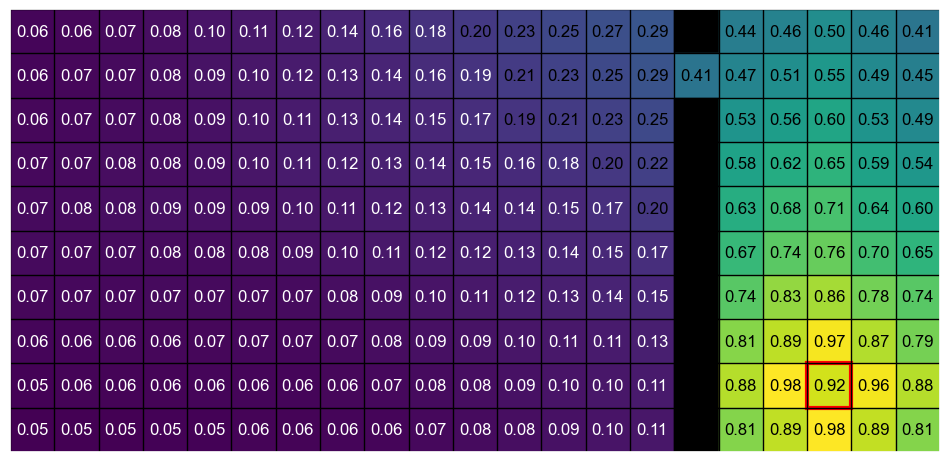

In [94]:
model_policy = derive_policy_from_q_table(q_table_model, states, actions)
V_model = extract_V_from_Q(q_table_model, states)

# Grid shape and walls for visualization
grid_shape = (env.rows, env.cols)
walls = env.walls  # Assuming walls are defined as a set of tuples (row, col)

# Draw the GridWorld with the optimal policy and value function
draw_simple_gridworld(
    grid_shape,
    walls,
    V_model,
    env.terminal_states,
    policy=None,
    enable_heatmap=True,
    figsize=(12, 7)
)

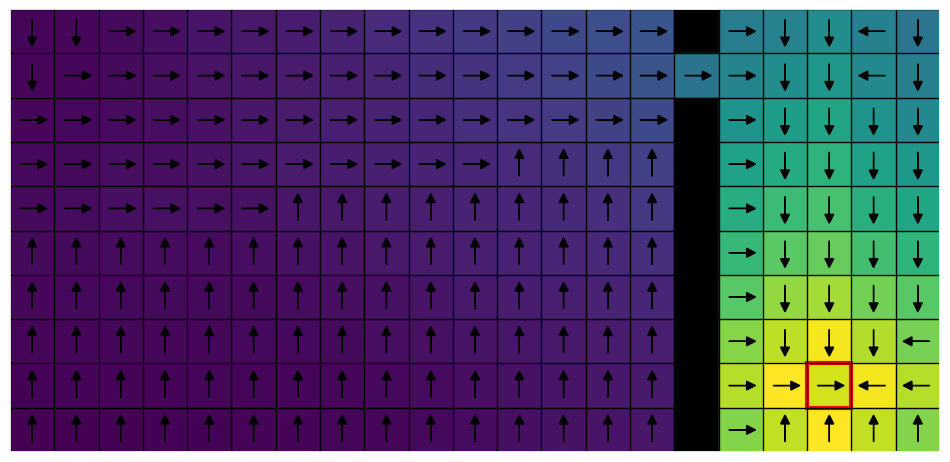

In [95]:
draw_simple_gridworld(
    grid_shape,
    walls,
    V_model,
    env.terminal_states,
    policy=model_policy,
    enable_heatmap=True,
    figsize=(12, 7)
)

In [96]:
q_table_model[0, 14]

{<Action.UP: 0>: 0.286533,
 <Action.RIGHT: 1>: 0.29280496,
 <Action.DOWN: 2>: 0.23939145,
 <Action.LEFT: 3>: 0.22623475}

In [97]:
model_policy[0, 14]

<Action.RIGHT: 1>

In [98]:
q_table_model[1, 15]

{<Action.UP: 0>: 0.3534771,
 <Action.RIGHT: 1>: 0.4069729,
 <Action.DOWN: 2>: 0.3737481,
 <Action.LEFT: 3>: 0.30766276}

### Making aggregations to compare Q table errors

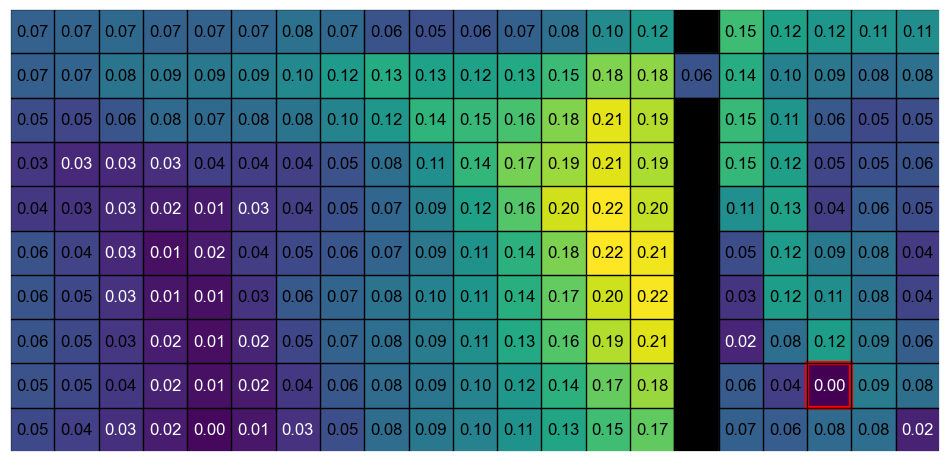

In [99]:
def compute_q_errors(optimal_q, network_q):
    """
    Compute the absolute error between the optimal Q-values and the network-generated Q-values.
    
    Args:
    optimal_q (dict): A dictionary of optimal Q-values.
    network_q (dict): A dictionary of network-generated Q-values.
    
    Returns:
    dict: A dictionary of absolute errors for each state-action pair.
    """
    errors = {}
    
    for state in optimal_q:
        errors[state] = {}
        for action in optimal_q[state]:
            if state in network_q and action in network_q[state]:
                errors[state][action] = abs(optimal_q[state][action] - network_q[state][action])
            else:
                errors[state][action] = float('inf')  # Assign a high error if the action/state pair is missing

    return errors

def aggregate_state_errors(q_errors):
    """
    Aggregate the absolute errors to get the sum for each state.

    Args:
    q_errors (dict): A dictionary of absolute errors for each state-action pair.

    Returns:
    dict: A dictionary of aggregated errors for each state.
    """
    state_errors = {}
    
    for state, actions in q_errors.items():
        state_errors[state] = sum(actions.values())
        
    return state_errors
    
def aggregate_total_errors(q_errors):
    """
    Aggregate the absolute errors to get the total sum over all states.

    Args:
    q_errors (dict): A dictionary of absolute errors for each state-action pair.

    Returns:
    float: The total sum of errors over all states.
    """
    total_error = sum(state_errors.values())
    
    return total_error

q_errors = compute_q_errors(optimal_value_function, q_table_model)


state_errors = aggregate_state_errors(q_errors)
state_errors

for key in env.terminal_states:
    state_errors[key] = 0

total_error = aggregate_total_errors(state_errors)
total_error

draw_simple_gridworld(
    grid_shape,
    walls,
    state_errors,
    env.terminal_states,
    policy=None,
    enable_heatmap=True,
    figsize=(12, 7)
)

In [100]:
# Initialize lists to store results
results = []
q_errors_list = []

for key in filtered_configs_dict:
    config = filtered_configs_dict[key]
    
    logger = logging.getLogger(__name__)

    agent = setup_dqn_agent(
        config=config,
        logger=logger,
        resume_training_path=key,
    )

    states = list(set([s for s, _ in agent.train_env.mdp.keys()]))
    actions = list(set([a for _, a in agent.train_env.mdp.keys()]))
    q_table_model = agent.compute_q_table(states, actions, agent.train_env.standardize_state)
    
    model_policy = derive_policy_from_q_table(q_table_model, states, actions)
    V_model = extract_V_from_Q(q_table_model, states)

    # Grid shape and walls for visualization
    grid_shape = (agent.train_env.rows, agent.train_env.cols)
    walls = agent.train_env.walls  # Assuming walls are defined as a set of tuples (row, col)
    
    q_errors = compute_q_errors(optimal_value_function, q_table_model)
    state_errors = aggregate_state_errors(q_errors)
    
    for terminal_state in agent.train_env.terminal_states:
        state_errors[terminal_state] = 0

    total_error = aggregate_total_errors(state_errors)

    # Collect necessary details from config
    replay_buffer_type = config['replay_buffer'].get('type')
    epsilon = config['agent_params']['args']['epsilon']
    learning_rate = config['optim']['args']['lr']
    hidden_size = config['agent_params']['args']['hidden_size']
    run_id = config['run_id']

    # Append results to the list
    results.append({
        'replay_buffer_type': replay_buffer_type,
        'epsilon': epsilon,
        'learning_rate': learning_rate,
        'hidden_size': hidden_size,
        'run_id': run_id,
        'total_error': total_error,
        'q_errors': q_errors
    })

    # Collect q_errors for averaging later
    q_errors_list.append(q_errors)
    
df = pd.DataFrame(results)

# Compute average Q-errors over all runs
average_q_errors = {}
for q_err in q_errors_list:
    for state, actions in q_err.items():
        if state not in average_q_errors:
            average_q_errors[state] = {}
        for action, error in actions.items():
            if action not in average_q_errors[state]:
                average_q_errors[state][action] = 0
            average_q_errors[state][action] += error

# Average the errors
num_runs = len(q_errors_list)
for state in average_q_errors:
    for action in average_q_errors[state]:
        average_q_errors[state][action] /= num_runs

# Display the DataFrame
df

,replay_buffer_type,epsilon,learning_rate,hidden_size,run_id,total_error,q_errors
0,UniqueReplayBuffer,"{'decay': 240000, 'end': 0.01, 'start': 1.0}",0.001,16,0,47.402230,"{(6, 18): {0: 0.19512954139709482, 1: 0.091834..."
1,UniqueReplayBuffer,"{'decay': 240000, 'end': 0.01, 'start': 1.0}",0.001,16,1,54.102979,"{(6, 18): {0: 0.1830134072303773, 1: 0.0966924..."
2,UniqueReplayBuffer,"{'decay': 240000, 'end': 0.01, 'start': 1.0}",0.001,16,10,44.665119,"{(6, 18): {0: 0.12371048116683969, 1: 0.055578..."
3,UniqueReplayBuffer,"{'decay': 240000, 'end': 0.01, 'start': 1.0}",0.001,16,11,25.059890,"{(6, 18): {0: 0.15572592401504526, 1: 0.157351..."
4,UniqueReplayBuffer,"{'decay': 240000, 'end': 0.01, 'start': 1.0}",0.001,16,12,38.471854,"{(6, 18): {0: 0.10546222114562998, 1: 0.147552..."
5,UniqueReplayBuffer,"{'decay': 240000, 'end': 0.01, 'start': 1.0}",0.001,16,13,17.469534,"{(6, 18): {0: 0.03350809001922617, 1: 0.017204..."
6,UniqueReplayBuffer,"{'decay': 240000, 'end': 0.01, 'start': 1.0}",0.001,16,14,80.920674,"{(6, 18): {0: 0.2357768394947053, 1: 0.2058453..."
7,UniqueReplayBuffer,"{'decay': 240000, 'end': 0.01, 'start': 1.0}",0.001,16,15,57.138339,"{(6, 18): {0: 0.1861649432182313, 1: 0.0940785..."
8,UniqueReplayBuffer,"{'decay': 240000, 'end': 0.01, 'start': 1.0}",0.001,16,16,22.477202,"{(6, 18): {0: 0.09969487571716318, 1: 0.051377..."
9,UniqueReplayBuffer,"{'decay': 240000, 'end': 0.01, 'start': 1.0}",0.001,16,17,22.691375,"{(6, 18): {0: 0.10476401233673105, 1: 0.033438..."


c:\Users\Chainsword\anaconda3\envs\phd_rl_algos\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.terminal_states to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.terminal_states` for environment variables or `env.get_wrapper_attr('terminal_states')` that will search the reminding wrappers.
  logger.warn(


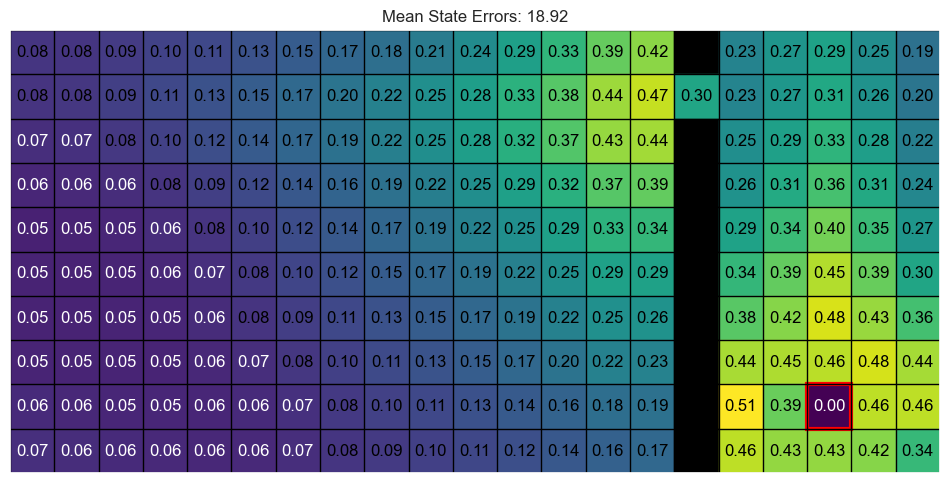

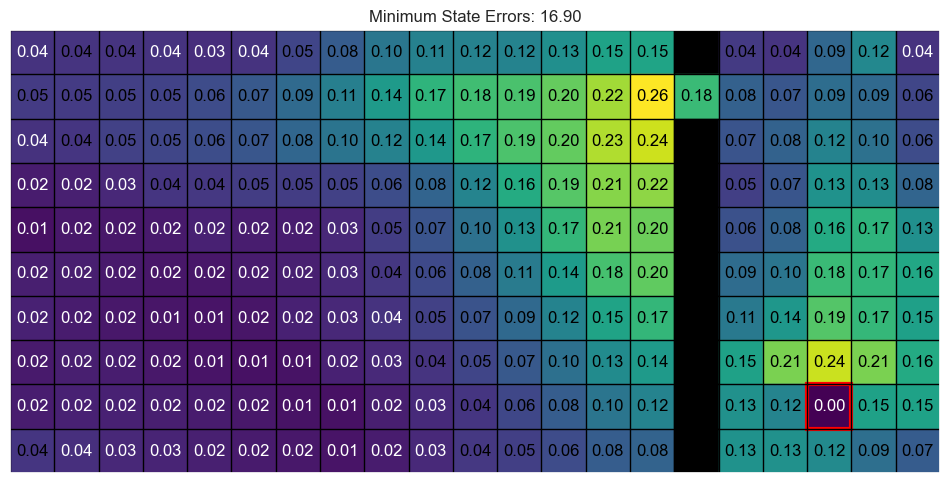

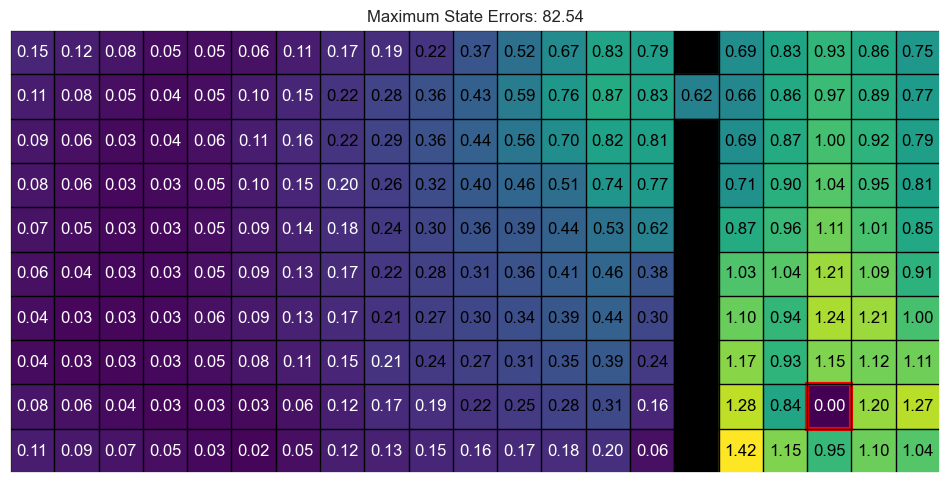

In [101]:
# Calculate mean state errors from the averaged Q-table errors
mean_state_errors = aggregate_state_errors(average_q_errors)
total_mean_error = aggregate_total_errors(mean_state_errors)

# Find the minimum and maximum error cases
min_error_run = min(results, key=lambda x: x['total_error'])
max_error_run = max(results, key=lambda x: x['total_error'])

min_q_errors = min_error_run['q_errors']
max_q_errors = max_error_run['q_errors']

min_state_errors = aggregate_state_errors(min_q_errors)
max_state_errors = aggregate_state_errors(max_q_errors)

# Ensure terminal state errors are zero
for key in agent.train_env.terminal_states:
    mean_state_errors[key] = 0
    min_state_errors[key] = 0
    max_state_errors[key] = 0

# Plot mean state errors
draw_simple_gridworld(
    grid_shape,
    walls,
    mean_state_errors,
    agent.train_env.terminal_states,
    enable_heatmap=True,
    figsize=(12, 7),
    title=f"Mean State Errors: {total_mean_error:.2f}"
)

# Plot minimum error case
draw_simple_gridworld(
    grid_shape,
    walls,
    min_state_errors,
    agent.train_env.terminal_states,
    enable_heatmap=True,
    figsize=(12, 7),
    title=f"Minimum State Errors: {min_error_run['total_error']:.2f}"
)

# Plot maximum error case
draw_simple_gridworld(
    grid_shape,
    walls,
    max_state_errors,
    agent.train_env.terminal_states,
    enable_heatmap=True,
    figsize=(12, 7),
    title=f"Maximum State Errors: {max_error_run['total_error']:.2f}"
)

### For normal replay buffer

In [102]:
root_dir = (
    r"D:\Work\repos\phd-research\experiments\dqn\results\2024Jul02-141049_configs"
)
matching_paths = find_matching_paths(root_dir)
config_data = read_yaml_files(matching_paths)

for key in config_data:
    print(key)

D:\Work\repos\phd-research\experiments\dqn\results\2024Jul02-141049_configs\0000_replay_buffer.type_ReplayBuffer__algorithm_default\0
D:\Work\repos\phd-research\experiments\dqn\results\2024Jul02-141049_configs\0000_replay_buffer.type_ReplayBuffer__algorithm_default\1
D:\Work\repos\phd-research\experiments\dqn\results\2024Jul02-141049_configs\0000_replay_buffer.type_ReplayBuffer__algorithm_default\10
D:\Work\repos\phd-research\experiments\dqn\results\2024Jul02-141049_configs\0000_replay_buffer.type_ReplayBuffer__algorithm_default\11
D:\Work\repos\phd-research\experiments\dqn\results\2024Jul02-141049_configs\0000_replay_buffer.type_ReplayBuffer__algorithm_default\12
D:\Work\repos\phd-research\experiments\dqn\results\2024Jul02-141049_configs\0000_replay_buffer.type_ReplayBuffer__algorithm_default\13
D:\Work\repos\phd-research\experiments\dqn\results\2024Jul02-141049_configs\0000_replay_buffer.type_ReplayBuffer__algorithm_default\14
D:\Work\repos\phd-research\experiments\dqn\results\2024Ju

In [103]:
def filter_keys_by_rb_type(d, rb_type):
    filtered_keys = {k: v for k, v in d.items() if f"replay_buffer.type_{rb_type}" in k}
    return filtered_keys

filtered_configs_dict = filter_keys_by_rb_type(config_data, "ReplayBuffer")
len(filtered_configs_dict.keys()) 

30

c:\Users\Chainsword\anaconda3\envs\phd_rl_algos\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.rows to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.rows` for environment variables or `env.get_wrapper_attr('rows')` that will search the reminding wrappers.
  logger.warn(
c:\Users\Chainsword\anaconda3\envs\phd_rl_algos\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.cols to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.cols` for environment variables or `env.get_wrapper_attr('cols')` that will search the reminding wrappers.
  logger.warn(
c:\Users\Chainsword\anaconda3\envs\phd_rl_algos\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.mdp to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.mdp` for environment vari

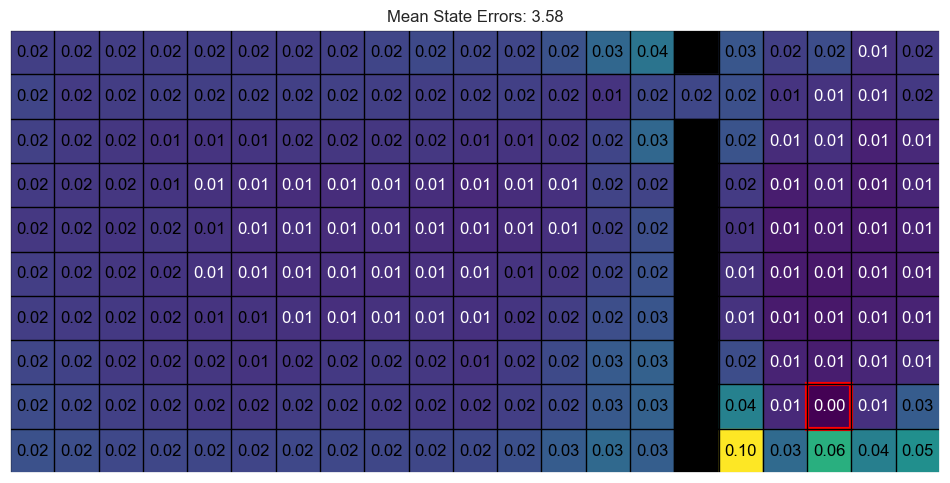

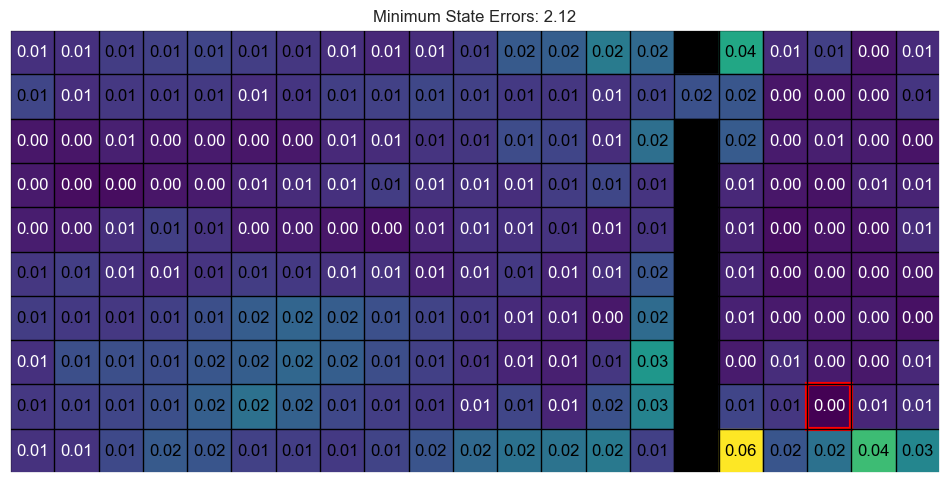

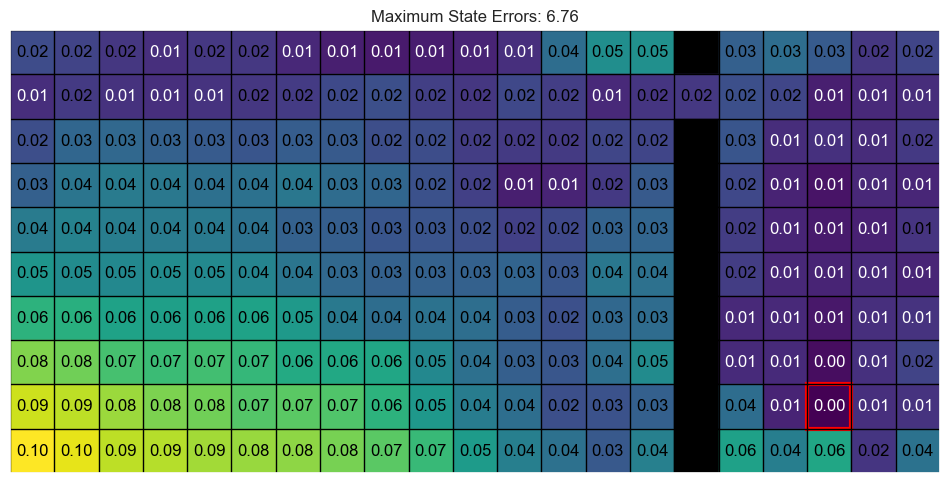

In [104]:
results = []
q_errors_list = []

for key in filtered_configs_dict:
    config = filtered_configs_dict[key]
    
    logger = logging.getLogger(__name__)

    agent = setup_dqn_agent(
        config=config,
        logger=logger,
        resume_training_path=key,
    )

    states = list(set([s for s, _ in agent.train_env.mdp.keys()]))
    actions = list(set([a for _, a in agent.train_env.mdp.keys()]))
    q_table_model = agent.compute_q_table(states, actions, agent.train_env.standardize_state)
    
    model_policy = derive_policy_from_q_table(q_table_model, states, actions)
    V_model = extract_V_from_Q(q_table_model, states)

    # Grid shape and walls for visualization
    grid_shape = (agent.train_env.rows, agent.train_env.cols)
    walls = agent.train_env.walls  # Assuming walls are defined as a set of tuples (row, col)
    
    q_errors = compute_q_errors(optimal_value_function, q_table_model)
    state_errors = aggregate_state_errors(q_errors)
    
    for terminal_state in agent.train_env.terminal_states:
        state_errors[terminal_state] = 0

    total_error = aggregate_total_errors(state_errors)

    # Collect necessary details from config
    replay_buffer_type = config['replay_buffer'].get('type')
    epsilon = config['agent_params']['args']['epsilon']
    learning_rate = config['optim']['args']['lr']
    hidden_size = config['agent_params']['args']['hidden_size']
    run_id = config['run_id']

    # Append results to the list
    results.append({
        'replay_buffer_type': replay_buffer_type,
        'epsilon': epsilon,
        'learning_rate': learning_rate,
        'hidden_size': hidden_size,
        'run_id': run_id,
        'total_error': total_error,
        'q_errors': q_errors
    })

    # Collect q_errors for averaging later
    q_errors_list.append(q_errors)
    
df = pd.DataFrame(results)

# Compute average Q-errors over all runs
average_q_errors = {}
for q_err in q_errors_list:
    for state, actions in q_err.items():
        if state not in average_q_errors:
            average_q_errors[state] = {}
        for action, error in actions.items():
            if action not in average_q_errors[state]:
                average_q_errors[state][action] = 0
            average_q_errors[state][action] += error

# Average the errors
num_runs = len(q_errors_list)
for state in average_q_errors:
    for action in average_q_errors[state]:
        average_q_errors[state][action] /= num_runs

# Display the DataFrame

# Calculate mean state errors from the averaged Q-table errors
mean_state_errors = aggregate_state_errors(average_q_errors)
total_mean_error = aggregate_total_errors(mean_state_errors)

# Find the minimum and maximum error cases
min_error_run = min(results, key=lambda x: x['total_error'])
max_error_run = max(results, key=lambda x: x['total_error'])

min_q_errors = min_error_run['q_errors']
max_q_errors = max_error_run['q_errors']

min_state_errors = aggregate_state_errors(min_q_errors)
max_state_errors = aggregate_state_errors(max_q_errors)

# Ensure terminal state errors are zero
for key in agent.train_env.terminal_states:
    mean_state_errors[key] = 0
    min_state_errors[key] = 0
    max_state_errors[key] = 0

# Plot mean state errors
draw_simple_gridworld(
    grid_shape,
    walls,
    mean_state_errors,
    agent.train_env.terminal_states,
    enable_heatmap=True,
    figsize=(12, 7),
    title=f"Mean State Errors: {total_mean_error:.2f}"
)

# Plot minimum error case
draw_simple_gridworld(
    grid_shape,
    walls,
    min_state_errors,
    agent.train_env.terminal_states,
    enable_heatmap=True,
    figsize=(12, 7),
    title=f"Minimum State Errors: {min_error_run['total_error']:.2f}"
)

# Plot maximum error case
draw_simple_gridworld(
    grid_shape,
    walls,
    max_state_errors,
    agent.train_env.terminal_states,
    enable_heatmap=True,
    figsize=(12, 7),
    title=f"Maximum State Errors: {max_error_run['total_error']:.2f}"
)